Test image

In [4]:
from PIL import Image
import torch
from torchvision.transforms import transforms
image = Image.open("data/weather-0/routes_town01_long_w0_06_23_09_24_57/topdown/0036.png")
image = image.convert("L")
image = image.crop((128, 0, 384, 256))
image_torch = transforms.ToTensor()(image).reshape(1,1,256,256)
image

TypeError: crop() takes from 1 to 2 positional arguments but 5 were given

test dim

In [1]:
import torch
class Pad(torch.nn.Module):
    def forward(self, x):
        return torch.nn.functional.pad(x, (0, 1, 0, 1),
                                       mode='constant',
                                       value=0)

class Resnet(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.GroupNorm(num_groups=32,
                               num_channels=dim_in,
                               eps=1e-6,
                               affine=True),
            torch.nn.SiLU(),
            torch.nn.Conv2d(dim_in,
                            dim_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.GroupNorm(num_groups=32,
                               num_channels=dim_out,
                               eps=1e-6,
                               affine=True),
            torch.nn.SiLU(),
            torch.nn.Conv2d(dim_out,
                            dim_out,
                            kernel_size=3,
                            stride=1,
                            padding=1),
        )
        self.res = None
        if dim_in != dim_out:
            self.res = torch.nn.Conv2d(dim_in,
                                       dim_out,
                                       kernel_size=1,
                                       stride=1,
                                       padding=0)
    def forward(self, x):
        #x -> [1, dim_in, resx, resy]
        res = x
        if self.res:
            #[1, dim_in, resx, resy] -> [1, dim_in, resx, resy]
            res = self.res(x)
        #[1, dim_in, resx, resy] -> [1, dim_in, resx, resy]
        return res + self.s(x)


c:\Users\adsfv\.conda\envs\diff_example\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
class Atten(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = torch.nn.GroupNorm(num_channels=512,
                                       num_groups=32,
                                       eps=1e-6,
                                       affine=True)
        self.q = torch.nn.Linear(512, 512)
        self.k = torch.nn.Linear(512, 512)
        self.v = torch.nn.Linear(512, 512)
        self.out = torch.nn.Linear(512, 512)

    def forward(self, x):
        #x -> [1, 512, 32, 32]
        res = x
        #norm,维度不变
        #[1, 512, 32, 32]
        x = self.norm(x)
        #[1, 512, 32, 32] -> [1, 512, 1024] -> [1, 1024, 512]
        x = x.flatten(start_dim=2).transpose(1, 2)
        #线性运算,维度不变
        #[1, 1024, 512]
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        #[1, 1024, 512] -> [1, 512, 1024]
        k = k.transpose(1, 2)
        #[1, 1024, 512] * [1, 512, 1024] -> [1, 1024, 1024]
        #0.044194173824159216 = 1 / 512**0.5
        #atten = q.bmm(k) * 0.044194173824159216
        #照理来说应该是等价的,但是却有很小的误差
        atten = torch.baddbmm(torch.empty(1, 1024, 1024, device=q.device),
                              q,
                              k,
                              beta=0,
                              alpha=0.044194173824159216)
        atten = torch.softmax(atten, dim=2)
        #[1, 1024, 1024] * [1, 1024, 512] -> [1, 1024, 512]
        atten = atten.bmm(v)
        #线性运算,维度不变
        #[1, 1024, 512]
        atten = self.out(atten)
        #[1, 1024, 512] -> [1, 512, 1024] -> [1, 512, 32, 32]
        atten = atten.transpose(1, 2).reshape(-1, 512, 32, 32)
        #残差连接,维度不变
        #[1, 512, 32, 32]
        atten = atten + res
        return atten



In [26]:
x = torch.randn(1, 1, 256, 256)
encoder = torch.nn.Sequential(
    # in
    torch.nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),

    # down
    torch.nn.Sequential(
        Resnet(128, 128),
        Resnet(128, 128),
        torch.nn.Sequential(
            Pad(),
            torch.nn.Conv2d(128, 128, 3, stride=2, padding=0),
        ),
    ),
    torch.nn.Sequential(
        Resnet(128, 256),
        Resnet(256, 256),
        torch.nn.Sequential(
            Pad(),
            torch.nn.Conv2d(256, 256, 3, stride=2, padding=0),
        ),
    ),
    torch.nn.Sequential(
        Resnet(256, 512),
        Resnet(512, 512),
        torch.nn.Sequential(
            Pad(),
            torch.nn.Conv2d(512, 512, 3, stride=2, padding=0),
        ),
    ),
    torch.nn.Sequential(
        Resnet(512, 512),
        Resnet(512, 512),
    ),
    # mid
    torch.nn.Sequential(
        Resnet(512, 512),
        Atten(),
        Resnet(512, 512),
    ),
        #out
    torch.nn.Sequential(
        torch.nn.GroupNorm(num_channels=512, num_groups=32, eps=1e-6),
        torch.nn.SiLU(),
        torch.nn.Conv2d(512, 8, 3, padding=1),
    ),

    #正态分布层
    torch.nn.Conv2d(8, 8, 1),
)
x = encoder(x)
x.shape

torch.Size([1, 8, 32, 32])

In [3]:
import torch

tensor = torch.randn(1, 1, 256, 256).byte()
tensor_squeezed = tensor.squeeze()
print(tensor_squeezed.shape,tensor_squeezed.dtype)

torch.Size([256, 256]) torch.uint8


In [18]:
import torch
tensor1 = torch.ones(1, 256, 256)
tensor2 = torch.ones(1, 256, 256)
tensor3 = torch.ones(1, 256, 256)

tensor = torch.cat((tensor1, tensor2, tensor3), dim=0)
tensor.shape

torch.Size([3, 256, 256])

In [10]:
import os

path = os.getcwd()
print(path)


c:\Users\adsfv\Desktop\毕设\diff_study\test


In [8]:
from torchsummary import summary
import os,torch,sys
sys.path.append('.')
sys.path.append('./models')
sys.path.append('./dataset')
from models.vae import VAE


vae_model = VAE(1,1)
summary(vae_model, (1, 256, 256))


ModuleNotFoundError: No module named 'models'

In [1]:
import torch

# 假设张量为tensor
tensor = torch.randn(26, 256, 256)  # 示例张量

# 对第0个维度进行softmax操作
softmax_tensor = torch.softmax(tensor, dim=0)

# 获取第0个维度中最大值的索引
max_index = torch.argmax(softmax_tensor, dim=0)

print(max_index)

c:\Users\adsfv\.conda\envs\diff_example\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[ 6, 15, 18,  ..., 12, 14,  1],
        [ 3, 22,  9,  ..., 22,  0,  6],
        [12, 17,  4,  ..., 17, 18,  3],
        ...,
        [10, 24, 11,  ..., 10,  0, 14],
        [10,  9, 22,  ..., 18, 11, 25],
        [19,  9, 21,  ..., 15, 25,  9]])


In [19]:
import torch

# 定义原始矩阵
tensor = torch.randint(0, 26, (256, 256), dtype=torch.uint8).unsqueeze(0).int()
print(tensor.shape)
print(tensor[0][1][1])
ones = torch.eye(26,dtype=torch.int32)
onehot = ones.index_select(0, tensor.view(-1)).reshape(1, 256, 256,26)
print(onehot.shape)
print(onehot[0][1][1])


torch.Size([1, 256, 256])
tensor(9, dtype=torch.int32)
torch.Size([1, 256, 256, 26])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=torch.int32)


In [25]:
import torch

# 定义原始矩阵
tensor = torch.randint(0, 26, (256, 256), dtype=torch.uint8).unsqueeze(0).int()
tensor.shape

torch.Size([1, 256, 256])

In [2]:
import torch
ones = torch.eye(26)
ones[3][3] = 100
ones[3][3]

tensor(100.)

In [5]:
x= b'\x90\x91\x92'
print(type(x))
print(' '.join([hex(i)[2:].zfill(2) for i in x]))

<class 'bytes'>
90 91 92


In [6]:
import numpy as np
import torch
a = torch.Tensor([[1, 2, np.nan], [2, np.nan, 4], [3, 4, 5]])
torch.any(torch.isnan(a))

c:\Users\adsfv\.conda\envs\diff_example\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(True)

In [17]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
image_full = Image.open("E:\\dataset\\weather-0\\data\\routes_town01_long_w0_06_23_02_24_19\\rgb_full\\0063.png")
image_front = image_full.crop((0, 0, 800, 600))
# center crop front
image_far = image_front.crop((200, 150, 600, 450))
image_left = image_full.crop((0, 600, 800, 1200))
image_right = image_full.crop((0, 1200, 800, 1800))

image_front = preprocess(image_front).unsqueeze(0).to(device)
image_left = preprocess(image_left).unsqueeze(0).to(device)
image_right = preprocess(image_right).unsqueeze(0).to(device)
image_far = preprocess(image_far).unsqueeze(0).to(device)

image = torch.cat((image_front, image_left, image_right,image_far), dim=0)
image.shape
with torch.no_grad():
    image_features = model.encode_image(image)
image_features.shape  # [1, 768]

AttributeError: 'Tensor' object has no attribute 'convert'

In [15]:
import sys
sys.path.append('..')
from models.resnet import Resnet
import torch

class Pad(torch.nn.Module):
    def forward(self, x):
        return torch.nn.functional.pad(x, (0, 1, 0, 1),
                                       mode='constant',
                                       value=0)


model = torch.nn.Sequential(
    torch.nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1),
    Resnet(64, 64),
    Resnet(64, 64),
    # torch.nn.Sequential(
    #     Pad(),
    #     torch.nn.Conv2d(64, 64, 3, stride=2, padding=0),
    # ),
    torch.nn.Conv2d(64, 77, kernel_size=3, stride=1, padding=1),
)

x = torch.randn(1, 5, 768)
x = x.reshape(1, 5, 32, 24)
y = model(x)
y = y.reshape(1, 77, 32*24)
print(y.shape)

torch.Size([1, 77, 768])


In [21]:
import torch
a = torch.tensor([[1,2,3,4],[5,6,7,8]]).reshape(-1)
a.reshape(-1,4)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [1]:
from torchsummary import summary
import sys
sys.path.append('..')
sys.path.append('../models')
sys.path.append('../dataset')
from models.image_encoder import ImageEncoder

ie = ImageEncoder(latent_dim=77)
summary(ie,(4, 3, 600, 800))

d:\anaconda\envs\diff_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 3, 600, 800])
torch.Size([8, 3, 224, 224])


AttributeError: 'NoneType' object has no attribute 'size'

In [2]:
from torchsummary import summary
import sys
sys.path.append('..')
sys.path.append('../models')
sys.path.append('../dataset')
from models.vae import VAE
from models.unet import UNet
from models.image_encoder import ImageEncoder

# image_encoder = ImageEncoder(77)
unet = UNet().to('cpu')
summary(unet,[(4,32,32),(77,768),(1)],batch_size=-1,device="cpu")


TypeError: Value after * must be an iterable, not int

In [1]:
import clip
from PIL import Image
from torchvision import transforms
import torch

clip_encoder, _ = clip.load('ViT-L/14', device='cuda')
preprocess = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]),
        ])
# bs1: 3.5g
# bs2: 4.5g
# bs4: 7.4g

for i in range(100):
    image = torch.randn(16, 3, 600, 800).cuda()
    image = preprocess(image)
    features = clip_encoder.encode_image(image)
    features = features.detach()
    print(i)

d:\anaconda\envs\diff_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
import sys
sys.path.append('..')
sys.path.append('../models')
sys.path.append('../dataset')
from dataset.carla_dataset import CarlaDataset

train_ds = CarlaDataset('E:\\remote\\dataset-full',weathers=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],towns=[1,2,3,4,5,6,7,10])
train_ds[0][0].lidar

In [2]:
import os
import numpy as np
path = os.path.join(os.path.expanduser("~"), 'Desktop','0001.npy')
np.load(path)


array([[14.963711  ,  0.        ,  2.6385028 ,  0.94103193],
       [14.628437  ,  0.19597656,  2.5796149 ,  0.94230926],
       [14.579062  ,  0.29300782,  2.5711977 ,  0.942492  ],
       ...,
       [-4.2053514 ,  0.16910157, -2.429927  ,  0.98074836],
       [-4.2072263 ,  0.11275391, -2.429927  ,  0.98074836],
       [-4.2078905 ,  0.08457031, -2.429927  ,  0.98074836]],
      dtype=float32)

64.28313 -63.539394 83.09958 -1.953125e-05


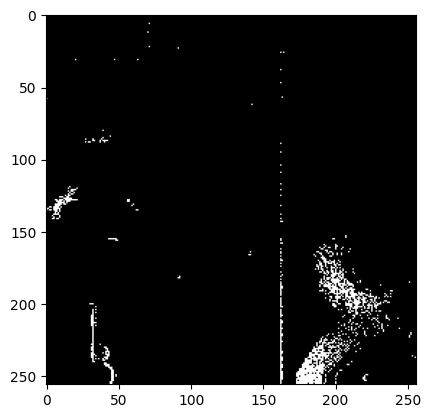

In [11]:
import open3d as o3d
path = os.path.join(os.path.expanduser("~"), 'Desktop','0001.npy')
pcd = o3d.geometry.PointCloud()
point = np.load(path)[:,:3]
point[:,0] = -point[:,0]
max_x = np.max(point[:,0])
min_x = np.min(point[:,0])
max_y = np.max(point[:,1])
min_y = np.min(point[:,1])
print(max_x,min_x,max_y,min_y)
point = point[(point[:,2] > -2.0)]
point = point[(point[:,0] > -22.5)]
point = point[(point[:,0] < 22.5)]
point = point[(point[:,1] < 45)]
point = point[(point[:,1] > 0)]
histogram = np.zeros((256,256))
for p in point:
    histogram[int((45-p[1])/45*256),int((p[0]+22.5)/45*256)] = 1
# pcd.points = o3d.utility.Vector3dVector(point)
# o3d.visualization.draw_geometries([pcd])
import matplotlib.pyplot as plt

plt.imshow(histogram,cmap='gray')
plt.show()

In [13]:
import cv2,torch
from PIL import Image
from torchvision.transforms import transforms
seg_tag = {
    0: [0,0,0], # Unlabeled
    1: [70,70,70], # Building
    2: [100,40,40], # Fence
    3: [55,90,80], # Other
    4: [220,20,60], # Pedestrian
    5: [153,153,153], # Pole
    6: [157,234,50], # RoadLine
    7: [128,64,128], # Road
    8: [244,35,232], # Sidewalk
    9: [107,142,35], # Vegetation
    10: [0,0,142], # Car
    11: [102,102,156], # Wall
    12: [220,220,0], # TrafficSign
    13: [70,130,180], # Sky
    14: [81,0,81],  # Ground
    15: [150,100,100], # Bridge
    16: [230,150,140], # RailTrack
    17: [180,165,180], # GuardRail
    18: [250,170,30], # TrafficLight
    19: [110,190,160], # Static
    20: [170,120,50], # Dynamic
    21: [45,60,150], # Water
    22: [145,170,100], # Terrain
    23: [255,0,0], # RedLight
    24: [255,255,0], # YellowLight
    25: [0,255,0], # GreenLight
}

def cvt_rgb_seg(seg:np.ndarray):
    # print(seg.shape)
    for i in seg_tag:
      seg = np.where(seg == [i,i,i], np.array(seg_tag[i]), seg)

    seg = seg.astype(np.uint8)
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
    return seg

def calc_crop(tar_x, tar_y):
    if tar_x > 512 or tar_y > 512:
        return (0,0,512,512)
    if tar_x < 0 or tar_y < 0:
        raise ValueError("Target size should be positive")
    if tar_x > 256 or tar_y > 256:
        x = (512 - tar_x) // 2
        return (x,0,x+tar_x,tar_y)
    else:
        x = (512 - tar_x) // 2
        y = 256 - tar_y
        return (x,y,x+tar_x,y+tar_y)
    
topdown_img = Image.open(os.path.join(os.path.expanduser("~"), 'Desktop','0001.png'))
topdown_img = topdown_img.crop(calc_crop(256, 256))
topdown_img = (transforms.ToTensor()(topdown_img) * 255).to(torch.uint8)
topdown_img = (torch.cat((topdown_img,topdown_img,topdown_img))).permute(1, 2, 0).numpy().astype(np.uint8)
topdown_img = cvt_rgb_seg(topdown_img)
# topdown_img = Image.fromarray(topdown_img)
# cv2.imshow('topdown',topdown_img)
cv2.imwrite(os.path.join(os.path.expanduser("~"), 'Desktop','0001_crop.png'),topdown_img)

True

In [44]:
# print max and min of point in x y z
max_x = np.max(point[:,0])
min_x = np.min(point[:,0])
max_y = np.max(point[:,1])
min_y = np.min(point[:,1])
max_z = np.max(point[:,2])
min_z = np.min(point[:,2])
print(max_x,min_x,max_y,min_y,max_z,min_z)

64.28313 -63.539394 83.09958 -1.953125e-05 14.398597 -8.902545


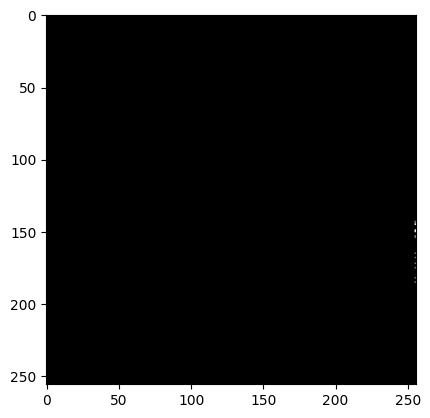

In [36]:
import matplotlib.pyplot as plt

plt.imshow(features,cmap='gray')
plt.show()